In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_Cinic10(nn.Module):
    def __init__(self):
        super(CNN_Cinic10, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(1024, 256)
        self.z_log_var = nn.Linear(1024, 256)

        self.decoder = nn.Sequential(
            nn.Linear(256, 1024),
            nn.Unflatten(1, (1024, 1, 1)),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),            
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

    def get_latent(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)

        return lat

In [3]:
mean = [0.47889522, 0.47227842, 0.43047404]
std = [0.24205776, 0.23828046, 0.25874835]

transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

root_dir = '/media/mountHDD2/data/cinic10'

trainset = ImageFolder(root=root_dir + "/train", transform=transform)
train_dl = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=24)
validset = ImageFolder(root=root_dir + "/valid", transform=transform)
valid_dl = DataLoader(validset, batch_size=64, shuffle=False, num_workers=24)
testset = ImageFolder(root=root_dir + "/test", transform=transform)
test_dl = DataLoader(testset, batch_size=64, shuffle=False, num_workers=24)

print(len(trainset), len(validset), len(testset))
print(len(train_dl), len(valid_dl), len(test_dl))

90000 90000 90000
1407 1407 1407


In [4]:
sample, _ = trainset[0]
print(sample.shape)

torch.Size([3, 32, 32])


In [5]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Cinic10().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [7]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(valid_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 308.26it/s]


Epoch: 0 - TrainRecLoss: 1613.5601349419198 - ValidRecLoss: 1327.992614225538
Epoch: 0 - TrainDivLoss: 54.55891663280886 - ValidDivLoss: 39.591026898555576


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 328.29it/s]


Epoch: 1 - TrainRecLoss: 1276.383369234325 - ValidRecLoss: 1201.1343469680753
Epoch: 1 - TrainDivLoss: 40.99841139684269 - ValidDivLoss: 41.38209067360255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 317.77it/s]


Epoch: 2 - TrainRecLoss: 1199.3253883085272 - ValidRecLoss: 1142.554064004406
Epoch: 2 - TrainDivLoss: 41.52587831249115 - ValidDivLoss: 42.5036417331438


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 330.59it/s]


Epoch: 3 - TrainRecLoss: 1157.430123074985 - ValidRecLoss: 1100.712943331265
Epoch: 3 - TrainDivLoss: 43.22335154432393 - ValidDivLoss: 46.7095212604276


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 332.92it/s]


Epoch: 4 - TrainRecLoss: 1104.0728021010323 - ValidRecLoss: 1057.2156743616947
Epoch: 4 - TrainDivLoss: 48.389283660801915 - ValidDivLoss: 49.271991496570756


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 338.27it/s]


Epoch: 5 - TrainRecLoss: 1078.1314243948366 - ValidRecLoss: 1045.981336494668
Epoch: 5 - TrainDivLoss: 48.716449111255244 - ValidDivLoss: 48.21471429972591


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 319.41it/s]


Epoch: 6 - TrainRecLoss: 1061.2620878239939 - ValidRecLoss: 1018.3961611966673
Epoch: 6 - TrainDivLoss: 48.7857047855727 - ValidDivLoss: 49.133692618710995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 310.95it/s]


Epoch: 7 - TrainRecLoss: 1042.295023513501 - ValidRecLoss: 1004.3709219015483
Epoch: 7 - TrainDivLoss: 50.42348672179525 - ValidDivLoss: 50.38699118228524


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 324.02it/s]


Epoch: 8 - TrainRecLoss: 1026.4292003900002 - ValidRecLoss: 994.7763527420792
Epoch: 8 - TrainDivLoss: 52.12229666476056 - ValidDivLoss: 52.36609489424651


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 305.56it/s]


Epoch: 9 - TrainRecLoss: 1012.9999522390142 - ValidRecLoss: 987.3421819127021
Epoch: 9 - TrainDivLoss: 52.71259204292433 - ValidDivLoss: 52.799158686005484


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 306.70it/s]


Epoch: 10 - TrainRecLoss: 1007.6309067889487 - ValidRecLoss: 978.7795627922053
Epoch: 10 - TrainDivLoss: 52.72998955949622 - ValidDivLoss: 52.98585168368103


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 316.60it/s]


Epoch: 11 - TrainRecLoss: 998.3998275572472 - ValidRecLoss: 971.1934511446326
Epoch: 11 - TrainDivLoss: 52.53863232306919 - ValidDivLoss: 53.53564379108486


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 334.41it/s]


Epoch: 12 - TrainRecLoss: 987.6421904411397 - ValidRecLoss: 958.7332904005017
Epoch: 12 - TrainDivLoss: 53.78211512562224 - ValidDivLoss: 54.413420741576715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 313.32it/s]


Epoch: 13 - TrainRecLoss: 975.8080590091535 - ValidRecLoss: 951.144610851643
Epoch: 13 - TrainDivLoss: 54.992430884192494 - ValidDivLoss: 56.24621460026007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 321.26it/s]


Epoch: 14 - TrainRecLoss: 966.6999483088186 - ValidRecLoss: 952.1551221293088
Epoch: 14 - TrainDivLoss: 56.364113428784165 - ValidDivLoss: 55.999276893903115


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 320.55it/s]


Epoch: 15 - TrainRecLoss: 962.6890136458472 - ValidRecLoss: 942.7708485378978
Epoch: 15 - TrainDivLoss: 56.58239507234597 - ValidDivLoss: 55.85343632430325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 309.35it/s]


Epoch: 16 - TrainRecLoss: 958.454766485652 - ValidRecLoss: 937.75830442514
Epoch: 16 - TrainDivLoss: 56.37462211722758 - ValidDivLoss: 56.06144152860228


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 315.58it/s]


Epoch: 17 - TrainRecLoss: 955.3297783282943 - ValidRecLoss: 937.3714496799623
Epoch: 17 - TrainDivLoss: 56.46477676369912 - ValidDivLoss: 57.518717325911425


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 304.38it/s]


Epoch: 18 - TrainRecLoss: 947.7878371118736 - ValidRecLoss: 931.2780303195934
Epoch: 18 - TrainDivLoss: 57.5053894379161 - ValidDivLoss: 57.298522911261564


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 324.04it/s]


Epoch: 19 - TrainRecLoss: 944.119415304893 - ValidRecLoss: 925.0798308827306
Epoch: 19 - TrainDivLoss: 57.64370150860947 - ValidDivLoss: 57.792853633986354


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 321.49it/s]


Epoch: 20 - TrainRecLoss: 940.9122491442064 - ValidRecLoss: 924.8508892913363
Epoch: 20 - TrainDivLoss: 57.55317424999202 - ValidDivLoss: 56.98364235038188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 331.24it/s]


Epoch: 21 - TrainRecLoss: 938.6168436729578 - ValidRecLoss: 925.9035305519348
Epoch: 21 - TrainDivLoss: 57.48631002213316 - ValidDivLoss: 57.47510793993637


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 312.69it/s]


Epoch: 22 - TrainRecLoss: 934.0262203040323 - ValidRecLoss: 917.3033571765197
Epoch: 22 - TrainDivLoss: 58.17017566217288 - ValidDivLoss: 57.481673809341615


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 315.66it/s]


Epoch: 23 - TrainRecLoss: 929.2991149078131 - ValidRecLoss: 915.0655099398376
Epoch: 23 - TrainDivLoss: 58.68304994551951 - ValidDivLoss: 57.96125728387568


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 309.84it/s]


Epoch: 24 - TrainRecLoss: 926.4011455609092 - ValidRecLoss: 911.5154376433263
Epoch: 24 - TrainDivLoss: 58.85280355902199 - ValidDivLoss: 59.16496646395794


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 332.53it/s]


Epoch: 25 - TrainRecLoss: 920.9617952890403 - ValidRecLoss: 905.0457279555071
Epoch: 25 - TrainDivLoss: 59.90472035790981 - ValidDivLoss: 60.27509554583042


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 321.20it/s]


Epoch: 26 - TrainRecLoss: 917.2846929120441 - ValidRecLoss: 901.9759934241669
Epoch: 26 - TrainDivLoss: 60.315893396894054 - ValidDivLoss: 60.40317464637349


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 329.65it/s]


Epoch: 27 - TrainRecLoss: 912.9110074453347 - ValidRecLoss: 900.8832315039617
Epoch: 27 - TrainDivLoss: 61.01096726006113 - ValidDivLoss: 61.32327290842019


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 308.90it/s]


Epoch: 28 - TrainRecLoss: 910.920585236485 - ValidRecLoss: 897.5473374269834
Epoch: 28 - TrainDivLoss: 61.23611998405538 - ValidDivLoss: 60.37805782011746


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 316.38it/s]


Epoch: 29 - TrainRecLoss: 908.3297012426706 - ValidRecLoss: 897.1179738861496
Epoch: 29 - TrainDivLoss: 61.320852850376504 - ValidDivLoss: 60.764381058943044


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 324.38it/s]


Epoch: 30 - TrainRecLoss: 906.3368395796548 - ValidRecLoss: 895.4370556406375
Epoch: 30 - TrainDivLoss: 61.279922021731636 - ValidDivLoss: 60.579851469081945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 308.26it/s]


Epoch: 31 - TrainRecLoss: 904.5497430450288 - ValidRecLoss: 891.8995665419416
Epoch: 31 - TrainDivLoss: 61.25235059639199 - ValidDivLoss: 61.30761777041394


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 320.15it/s]


Epoch: 32 - TrainRecLoss: 902.3152597694424 - ValidRecLoss: 892.6307600139301
Epoch: 32 - TrainDivLoss: 61.14998089885915 - ValidDivLoss: 60.50632098590387


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 320.50it/s]


Epoch: 33 - TrainRecLoss: 899.8946177490061 - ValidRecLoss: 890.6976411625606
Epoch: 33 - TrainDivLoss: 60.92326643997333 - ValidDivLoss: 60.5395435964968


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 321.39it/s]


Epoch: 34 - TrainRecLoss: 899.0059531617859 - ValidRecLoss: 888.1410867112193
Epoch: 34 - TrainDivLoss: 60.82056873812265 - ValidDivLoss: 61.01975794658647


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 315.90it/s]


Epoch: 35 - TrainRecLoss: 897.6072464911075 - ValidRecLoss: 889.2469162280117
Epoch: 35 - TrainDivLoss: 60.54576216577721 - ValidDivLoss: 60.17122640928311


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 323.95it/s]


Epoch: 36 - TrainRecLoss: 895.879465890761 - ValidRecLoss: 886.5146575038451
Epoch: 36 - TrainDivLoss: 60.33479436238607 - ValidDivLoss: 59.71759931975082


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 324.97it/s]


Epoch: 37 - TrainRecLoss: 894.4795809422475 - ValidRecLoss: 886.1045707263418
Epoch: 37 - TrainDivLoss: 60.10964337628872 - ValidDivLoss: 59.45132602726896


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 310.37it/s]


Epoch: 38 - TrainRecLoss: 892.3317678488139 - ValidRecLoss: 882.6649996087157
Epoch: 38 - TrainDivLoss: 60.08170672689843 - ValidDivLoss: 60.16403303166697


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 314.76it/s]


Epoch: 39 - TrainRecLoss: 888.7048213175195 - ValidRecLoss: 881.1182278088838
Epoch: 39 - TrainDivLoss: 60.67698101973652 - ValidDivLoss: 60.67041220051563


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 319.99it/s]


Epoch: 40 - TrainRecLoss: 886.3023875113828 - ValidRecLoss: 879.8601775667561
Epoch: 40 - TrainDivLoss: 60.88389595264904 - ValidDivLoss: 60.644184014944635


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 322.38it/s]


Epoch: 41 - TrainRecLoss: 884.9691775063716 - ValidRecLoss: 879.1517556738836
Epoch: 41 - TrainDivLoss: 60.911801344296066 - ValidDivLoss: 60.606953472470934


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 321.38it/s]


Epoch: 42 - TrainRecLoss: 883.3758086399059 - ValidRecLoss: 876.2685831011655
Epoch: 42 - TrainDivLoss: 61.03393803307073 - ValidDivLoss: 60.92010593210964


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 308.15it/s]


Epoch: 43 - TrainRecLoss: 882.6863991548257 - ValidRecLoss: 876.9761324342295
Epoch: 43 - TrainDivLoss: 61.079745872188475 - ValidDivLoss: 60.345253107305446


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 324.65it/s]


Epoch: 44 - TrainRecLoss: 881.0741902061956 - ValidRecLoss: 875.8221758942105
Epoch: 44 - TrainDivLoss: 61.04767133635499 - ValidDivLoss: 61.59381148793126


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 318.34it/s]


Epoch: 45 - TrainRecLoss: 880.4657003244104 - ValidRecLoss: 873.8480642355327
Epoch: 45 - TrainDivLoss: 61.16621788800313 - ValidDivLoss: 61.69332103553018


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 308.29it/s]


Epoch: 46 - TrainRecLoss: 879.4545729256896 - ValidRecLoss: 874.2913923771905
Epoch: 46 - TrainDivLoss: 61.1969931683137 - ValidDivLoss: 60.8583078147167


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 304.05it/s]


Epoch: 47 - TrainRecLoss: 878.3808947294082 - ValidRecLoss: 874.1029174631169
Epoch: 47 - TrainDivLoss: 61.28283612238403 - ValidDivLoss: 60.95624580464638


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 315.81it/s]


Epoch: 48 - TrainRecLoss: 877.0409684279496 - ValidRecLoss: 871.4356667763304
Epoch: 48 - TrainDivLoss: 61.45607359289021 - ValidDivLoss: 61.93964700488733


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 329.22it/s]


Epoch: 49 - TrainRecLoss: 874.0360463134939 - ValidRecLoss: 870.6915127253312
Epoch: 49 - TrainDivLoss: 61.9906233765169 - ValidDivLoss: 61.86471707548075


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 309.29it/s]


Epoch: 50 - TrainRecLoss: 872.5526763764187 - ValidRecLoss: 868.345633218707
Epoch: 50 - TrainDivLoss: 62.2339163307781 - ValidDivLoss: 62.06937278579463


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 335.25it/s]


Epoch: 51 - TrainRecLoss: 870.8043029394739 - ValidRecLoss: 866.3627982393765
Epoch: 51 - TrainDivLoss: 62.36067123521535 - ValidDivLoss: 62.00186891427003


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 312.03it/s]


Epoch: 52 - TrainRecLoss: 869.8682194583027 - ValidRecLoss: 869.5980594637721
Epoch: 52 - TrainDivLoss: 62.3519748614541 - ValidDivLoss: 62.27875708855885


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 313.21it/s]


Epoch: 53 - TrainRecLoss: 868.7677401913423 - ValidRecLoss: 866.8509419325318
Epoch: 53 - TrainDivLoss: 62.43783539783556 - ValidDivLoss: 62.47062415778425


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 303.55it/s]


Epoch: 54 - TrainRecLoss: 867.7271146794626 - ValidRecLoss: 867.3251502627418
Epoch: 54 - TrainDivLoss: 62.45676534635087 - ValidDivLoss: 61.92737724125258


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 311.84it/s]


Epoch: 55 - TrainRecLoss: 866.5616483708689 - ValidRecLoss: 865.2114709611471
Epoch: 55 - TrainDivLoss: 62.39948406639723 - ValidDivLoss: 62.08467152479615


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 322.64it/s]


Epoch: 56 - TrainRecLoss: 865.6706908659132 - ValidRecLoss: 865.0840038958389
Epoch: 56 - TrainDivLoss: 62.477539320066626 - ValidDivLoss: 62.03327926169411


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 312.61it/s]


Epoch: 57 - TrainRecLoss: 864.8903875832195 - ValidRecLoss: 867.4007781570315
Epoch: 57 - TrainDivLoss: 62.464524483968795 - ValidDivLoss: 61.82693464093456


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 315.91it/s]


Epoch: 58 - TrainRecLoss: 864.1356068863967 - ValidRecLoss: 870.1867101217892
Epoch: 58 - TrainDivLoss: 62.620038231129165 - ValidDivLoss: 62.89082955941293


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 313.67it/s]


Epoch: 59 - TrainRecLoss: 862.7817207558746 - ValidRecLoss: 863.9390365936778
Epoch: 59 - TrainDivLoss: 62.85883270838452 - ValidDivLoss: 62.15622536849705


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 310.85it/s]


Epoch: 60 - TrainRecLoss: 860.4203135497874 - ValidRecLoss: 859.7163834887018
Epoch: 60 - TrainDivLoss: 63.30625220639704 - ValidDivLoss: 62.96993452179237


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 332.05it/s]


Epoch: 61 - TrainRecLoss: 859.4370543609381 - ValidRecLoss: 860.6860600778543
Epoch: 61 - TrainDivLoss: 63.47445500583283 - ValidDivLoss: 63.20733295540989


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 305.39it/s]


Epoch: 62 - TrainRecLoss: 857.823704180687 - ValidRecLoss: 858.3274710518973
Epoch: 62 - TrainDivLoss: 63.60180449333272 - ValidDivLoss: 63.337096275974865


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 307.54it/s]


Epoch: 63 - TrainRecLoss: 856.596318378462 - ValidRecLoss: 856.7854866944227
Epoch: 63 - TrainDivLoss: 63.89783758395262 - ValidDivLoss: 63.69164715613044


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 315.28it/s]


Epoch: 64 - TrainRecLoss: 854.7349212798313 - ValidRecLoss: 853.8077144663471
Epoch: 64 - TrainDivLoss: 64.36634384730054 - ValidDivLoss: 64.00889571677223


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 315.45it/s]


Epoch: 65 - TrainRecLoss: 853.68319270521 - ValidRecLoss: 854.3325801326098
Epoch: 65 - TrainDivLoss: 64.58270554857722 - ValidDivLoss: 64.70378340264966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 316.61it/s]


Epoch: 66 - TrainRecLoss: 851.9012054248151 - ValidRecLoss: 854.0979383695015
Epoch: 66 - TrainDivLoss: 64.64353015631247 - ValidDivLoss: 64.71169220545484


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 324.66it/s]


Epoch: 67 - TrainRecLoss: 851.1643408671625 - ValidRecLoss: 852.4858447022699
Epoch: 67 - TrainDivLoss: 64.72812740702788 - ValidDivLoss: 64.51064655165682


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 321.56it/s]


Epoch: 68 - TrainRecLoss: 850.1950444571922 - ValidRecLoss: 856.9256366656533
Epoch: 68 - TrainDivLoss: 64.81498246508113 - ValidDivLoss: 64.05629683591495


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 304.39it/s]


Epoch: 69 - TrainRecLoss: 849.6617417325343 - ValidRecLoss: 850.8263598606785
Epoch: 69 - TrainDivLoss: 64.84918205841433 - ValidDivLoss: 64.85734552683013


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 303.17it/s]


Epoch: 70 - TrainRecLoss: 848.7484369447405 - ValidRecLoss: 850.1392121684407
Epoch: 70 - TrainDivLoss: 64.89775721232097 - ValidDivLoss: 64.54683391947906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 318.26it/s]


Epoch: 71 - TrainRecLoss: 848.2129083672736 - ValidRecLoss: 849.8924636678147
Epoch: 71 - TrainDivLoss: 64.88512840352332 - ValidDivLoss: 64.88829467545695


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 298.61it/s]


Epoch: 72 - TrainRecLoss: 847.1486475442264 - ValidRecLoss: 849.222720712148
Epoch: 72 - TrainDivLoss: 64.93215537054283 - ValidDivLoss: 65.4227692821641


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 308.34it/s]


Epoch: 73 - TrainRecLoss: 846.7758783856943 - ValidRecLoss: 849.9938082284934
Epoch: 73 - TrainDivLoss: 64.89496506810951 - ValidDivLoss: 64.24046881485256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 315.35it/s]


Epoch: 74 - TrainRecLoss: 846.0405292524542 - ValidRecLoss: 849.9550699262477
Epoch: 74 - TrainDivLoss: 64.99265178417431 - ValidDivLoss: 64.81235326836104


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 307.41it/s]


Epoch: 75 - TrainRecLoss: 845.8105668296353 - ValidRecLoss: 848.7830596685241
Epoch: 75 - TrainDivLoss: 65.02560027880963 - ValidDivLoss: 64.66131797036806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 308.58it/s]


Epoch: 76 - TrainRecLoss: 844.9352772705251 - ValidRecLoss: 848.3595069174912
Epoch: 76 - TrainDivLoss: 65.0426752189414 - ValidDivLoss: 64.49394190014891


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 318.89it/s]


Epoch: 77 - TrainRecLoss: 844.3204568674485 - ValidRecLoss: 848.9761952696409
Epoch: 77 - TrainDivLoss: 65.03016810630685 - ValidDivLoss: 64.64018052134348


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 317.75it/s]


Epoch: 78 - TrainRecLoss: 844.1286586823833 - ValidRecLoss: 859.9710156319408
Epoch: 78 - TrainDivLoss: 65.07504238841715 - ValidDivLoss: 65.03023558605115


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 305.55it/s]


Epoch: 79 - TrainRecLoss: 843.5806879126271 - ValidRecLoss: 848.8155945084496
Epoch: 79 - TrainDivLoss: 65.06377586033976 - ValidDivLoss: 64.94634580849414


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 297.13it/s]


Epoch: 80 - TrainRecLoss: 843.338979020217 - ValidRecLoss: 851.5924886718403
Epoch: 80 - TrainDivLoss: 65.10296825796641 - ValidDivLoss: 64.89222143318268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 314.38it/s]


Epoch: 81 - TrainRecLoss: 842.7315397933602 - ValidRecLoss: 848.4529515248117
Epoch: 81 - TrainDivLoss: 65.11610262124523 - ValidDivLoss: 64.62978332129114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 327.54it/s]


Epoch: 82 - TrainRecLoss: 842.4504471313217 - ValidRecLoss: 847.3165679259256
Epoch: 82 - TrainDivLoss: 65.14557893342301 - ValidDivLoss: 64.87791026968776


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 318.37it/s]


Epoch: 83 - TrainRecLoss: 842.4038937046075 - ValidRecLoss: 850.8952168652413
Epoch: 83 - TrainDivLoss: 65.14389575451253 - ValidDivLoss: 65.11039376546918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 318.25it/s]


Epoch: 84 - TrainRecLoss: 841.6908169375639 - ValidRecLoss: 847.7884498059368
Epoch: 84 - TrainDivLoss: 65.17189497903635 - ValidDivLoss: 65.40879973334968


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 319.27it/s]


Epoch: 85 - TrainRecLoss: 841.5645575397982 - ValidRecLoss: 847.424296299786
Epoch: 85 - TrainDivLoss: 65.17997466780737 - ValidDivLoss: 65.5058527108025


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 310.10it/s]


Epoch: 86 - TrainRecLoss: 841.3632311465135 - ValidRecLoss: 849.7784852852784
Epoch: 86 - TrainDivLoss: 65.20088218303971 - ValidDivLoss: 64.32284803193939


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 323.94it/s]


Epoch: 87 - TrainRecLoss: 840.9586503951365 - ValidRecLoss: 846.9986509148246
Epoch: 87 - TrainDivLoss: 65.2539468641898 - ValidDivLoss: 65.29734448159766


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 330.86it/s]


Epoch: 88 - TrainRecLoss: 840.8333988365927 - ValidRecLoss: 847.8521133780733
Epoch: 88 - TrainDivLoss: 65.21550864875105 - ValidDivLoss: 65.42978685564748


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 313.04it/s]


Epoch: 89 - TrainRecLoss: 840.3306185919593 - ValidRecLoss: 846.4006670617684
Epoch: 89 - TrainDivLoss: 65.20268876618668 - ValidDivLoss: 65.25745405944087


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 315.91it/s]


Epoch: 90 - TrainRecLoss: 840.41120673141 - ValidRecLoss: 846.8359109299693
Epoch: 90 - TrainDivLoss: 65.24059838984313 - ValidDivLoss: 64.898533157533


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 318.45it/s]


Epoch: 91 - TrainRecLoss: 840.0168742469294 - ValidRecLoss: 847.5286892997345
Epoch: 91 - TrainDivLoss: 65.2692309273162 - ValidDivLoss: 64.93553221810348


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 314.78it/s]


Epoch: 92 - TrainRecLoss: 840.0529062017619 - ValidRecLoss: 846.7454085251754
Epoch: 92 - TrainDivLoss: 65.21498319385911 - ValidDivLoss: 65.0002319509456


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 326.74it/s]


Epoch: 93 - TrainRecLoss: 839.9642179986646 - ValidRecLoss: 846.7359623261691
Epoch: 93 - TrainDivLoss: 65.19042605987744 - ValidDivLoss: 64.9178105498682


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 325.27it/s]


Epoch: 94 - TrainRecLoss: 839.7908671798651 - ValidRecLoss: 846.3803692067356
Epoch: 94 - TrainDivLoss: 65.23237792600023 - ValidDivLoss: 65.34501074795699


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 312.99it/s]


Epoch: 95 - TrainRecLoss: 839.954316985802 - ValidRecLoss: 852.0654104052492
Epoch: 95 - TrainDivLoss: 65.26185274158036 - ValidDivLoss: 65.17450220939024


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 308.99it/s]


Epoch: 96 - TrainRecLoss: 839.4676105469445 - ValidRecLoss: 846.8080924548574
Epoch: 96 - TrainDivLoss: 65.23408184580202 - ValidDivLoss: 65.4049232336504


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 313.07it/s]


Epoch: 97 - TrainRecLoss: 839.899227963836 - ValidRecLoss: 847.551516947038
Epoch: 97 - TrainDivLoss: 65.22973969818094 - ValidDivLoss: 65.30354055582248


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 310.34it/s]


Epoch: 98 - TrainRecLoss: 840.1038252688844 - ValidRecLoss: 847.4984532988656
Epoch: 98 - TrainDivLoss: 65.25688146443424 - ValidDivLoss: 65.13067100161598


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 330.30it/s]

Epoch: 99 - TrainRecLoss: 839.7117343406434 - ValidRecLoss: 846.524503467942
Epoch: 99 - TrainDivLoss: 65.28369234704599 - ValidDivLoss: 65.60571353318595


In [8]:
model.eval()
with torch.no_grad():
    va_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for valid_img, _ in tqdm(test_dl):
        valid_img = valid_img.to(device)

        gen_img, valid_mu, valid_lv = model(valid_img)
        valid_rec_loss = loss_fn(gen_img, valid_img)
        valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
        valid_loss = valid_rec_loss + valid_kl_loss

        va_total_loss["rec_loss"] += valid_rec_loss.item()
        va_total_loss["kl_loss"] += valid_kl_loss.item()

print(f"TestRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
print(f"TestDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:04<00:00, 302.33it/s]

TestRecLoss: 846.2230707641688
TestDivLoss: 65.59904131587719


In [9]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(40, 40))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

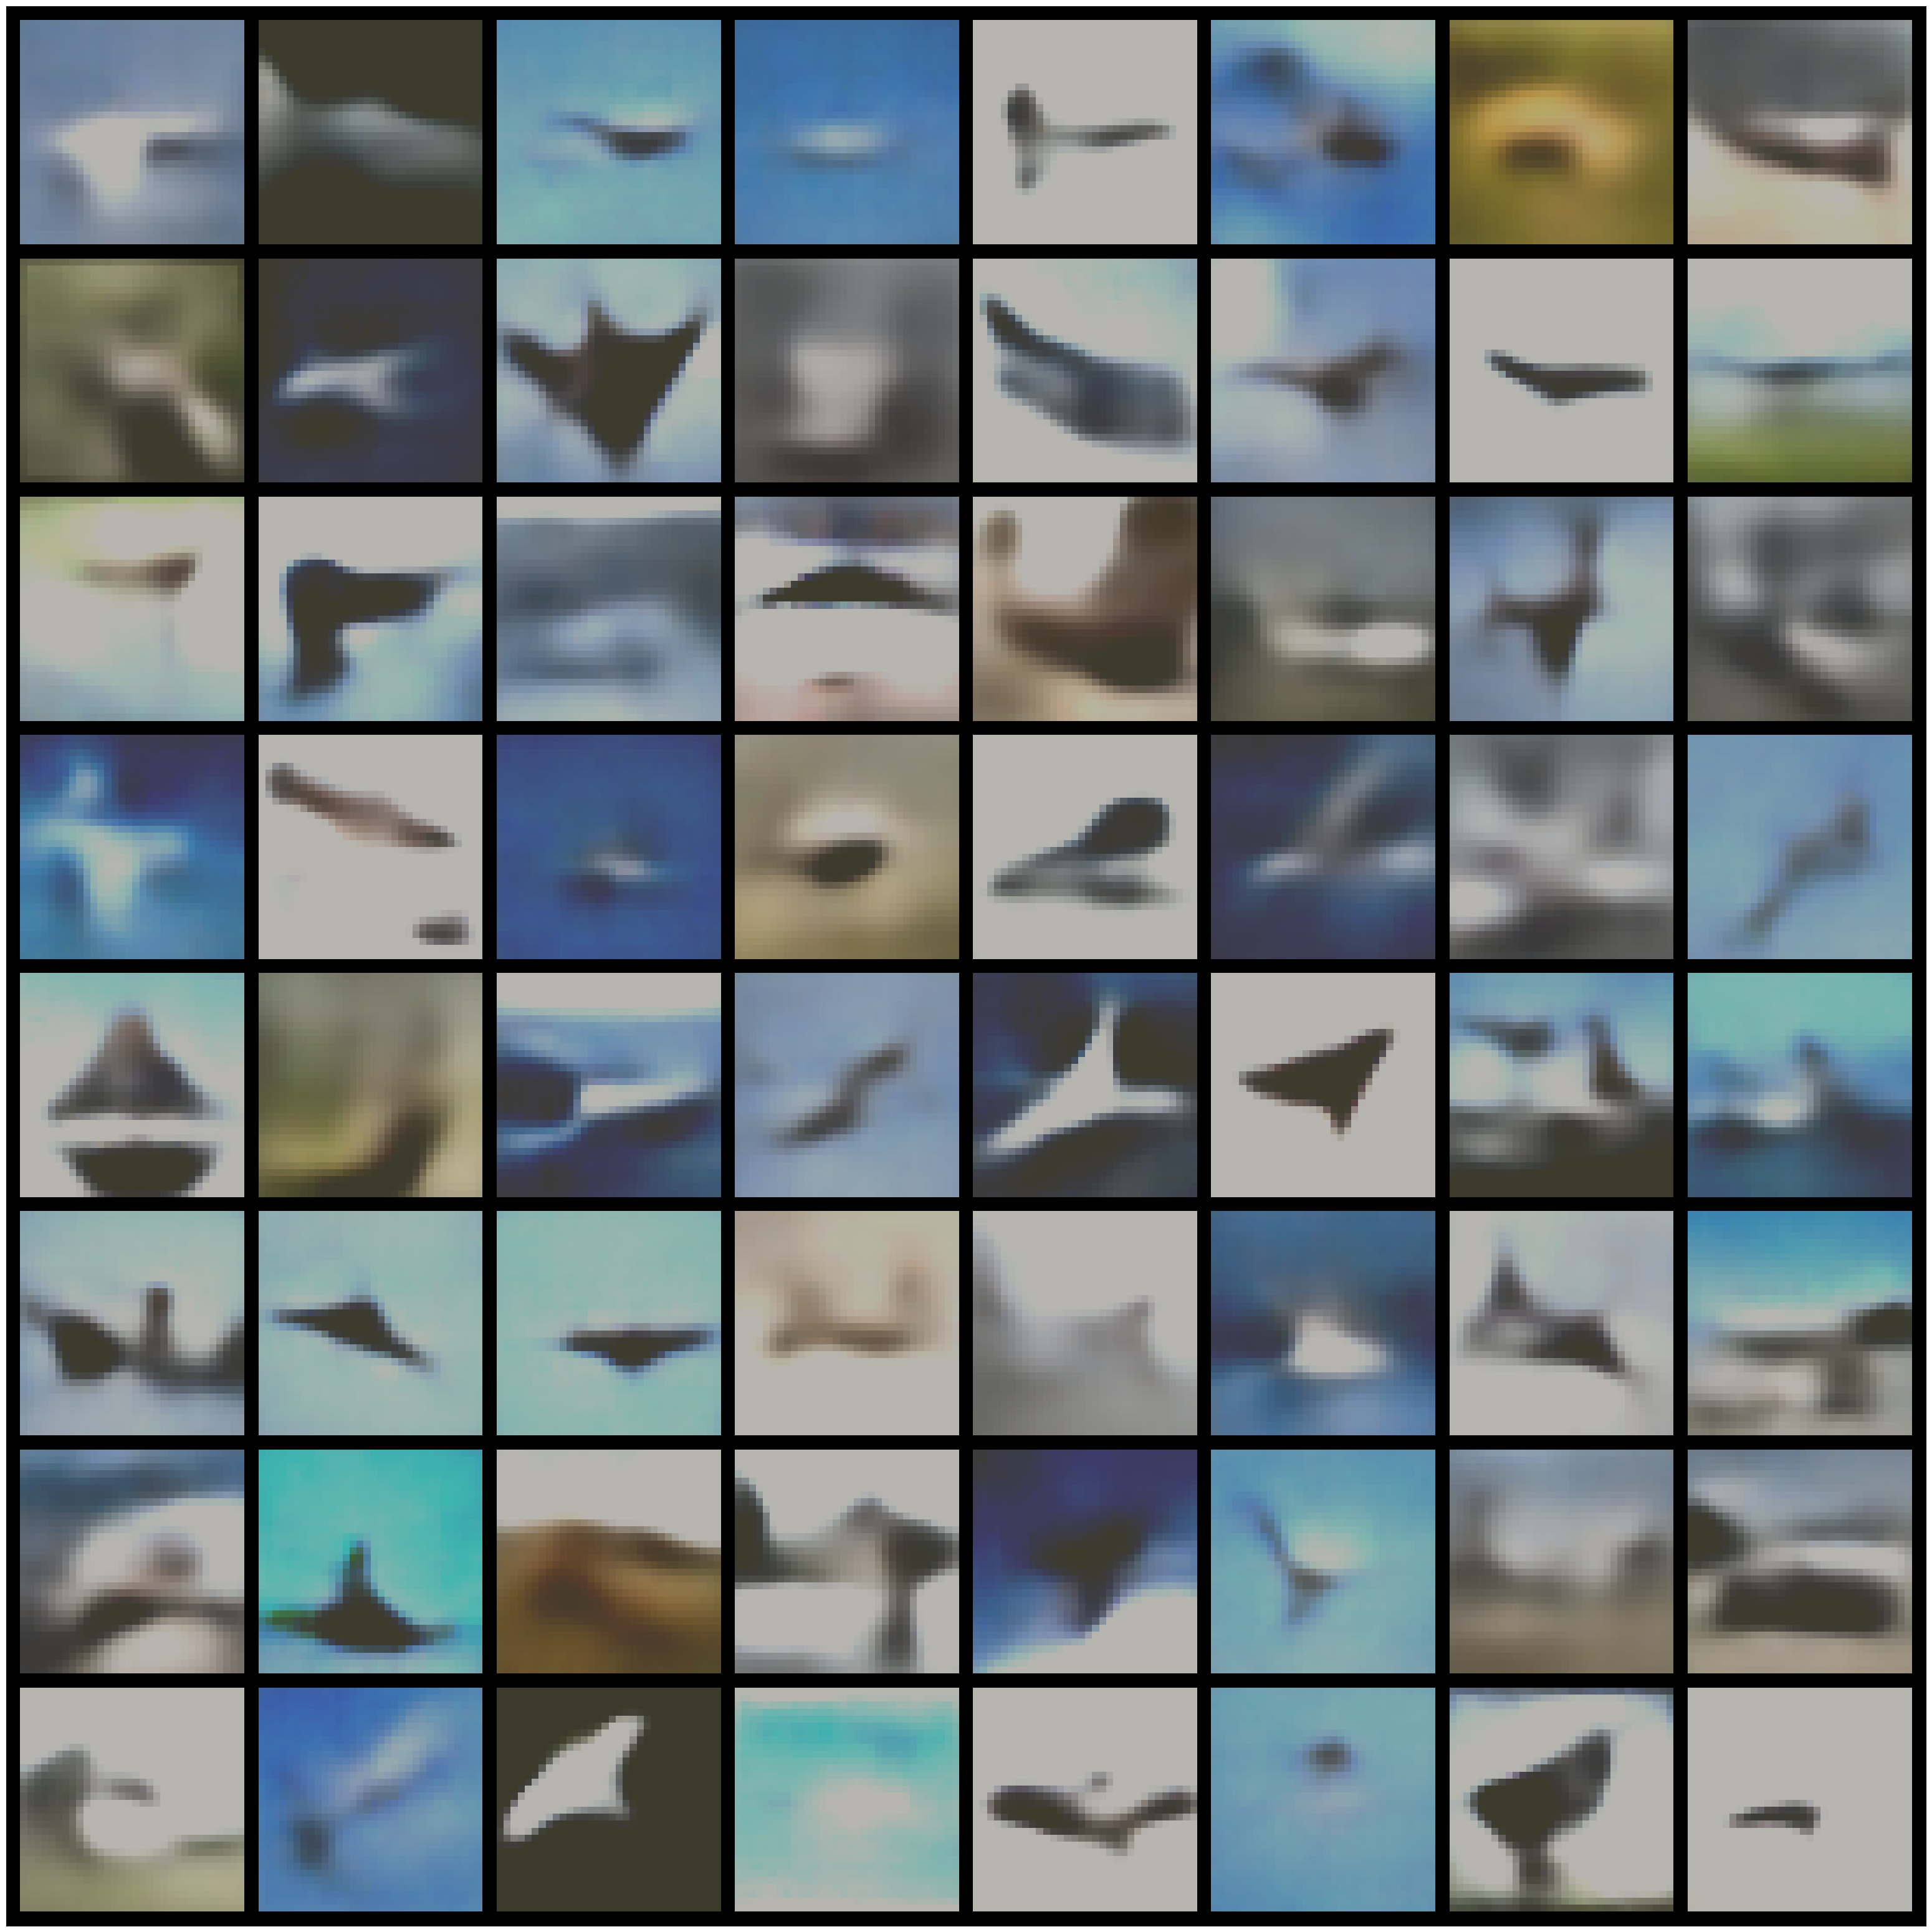

In [15]:
test_input, _ = next(iter(test_dl))
test_input = test_input.to(device)

# mean = [0.47889522, 0.47227842, 0.43047404]
# std = [0.24205776, 0.23828046, 0.25874835]

invnorm = transforms.Compose(
    [
        transforms.Normalize(mean = [0., 0., 0.], std = [1/0.24205776, 1/0.23828046, 1/0.25874835]),
        transforms.Normalize(mean = [-0.47889522, -0.47227842, -0.43047404], std = [1., 1., 1.]),
    ]
)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

    inv_recons = invnorm(recons)

grid = make_grid(inv_recons)
show(grid)

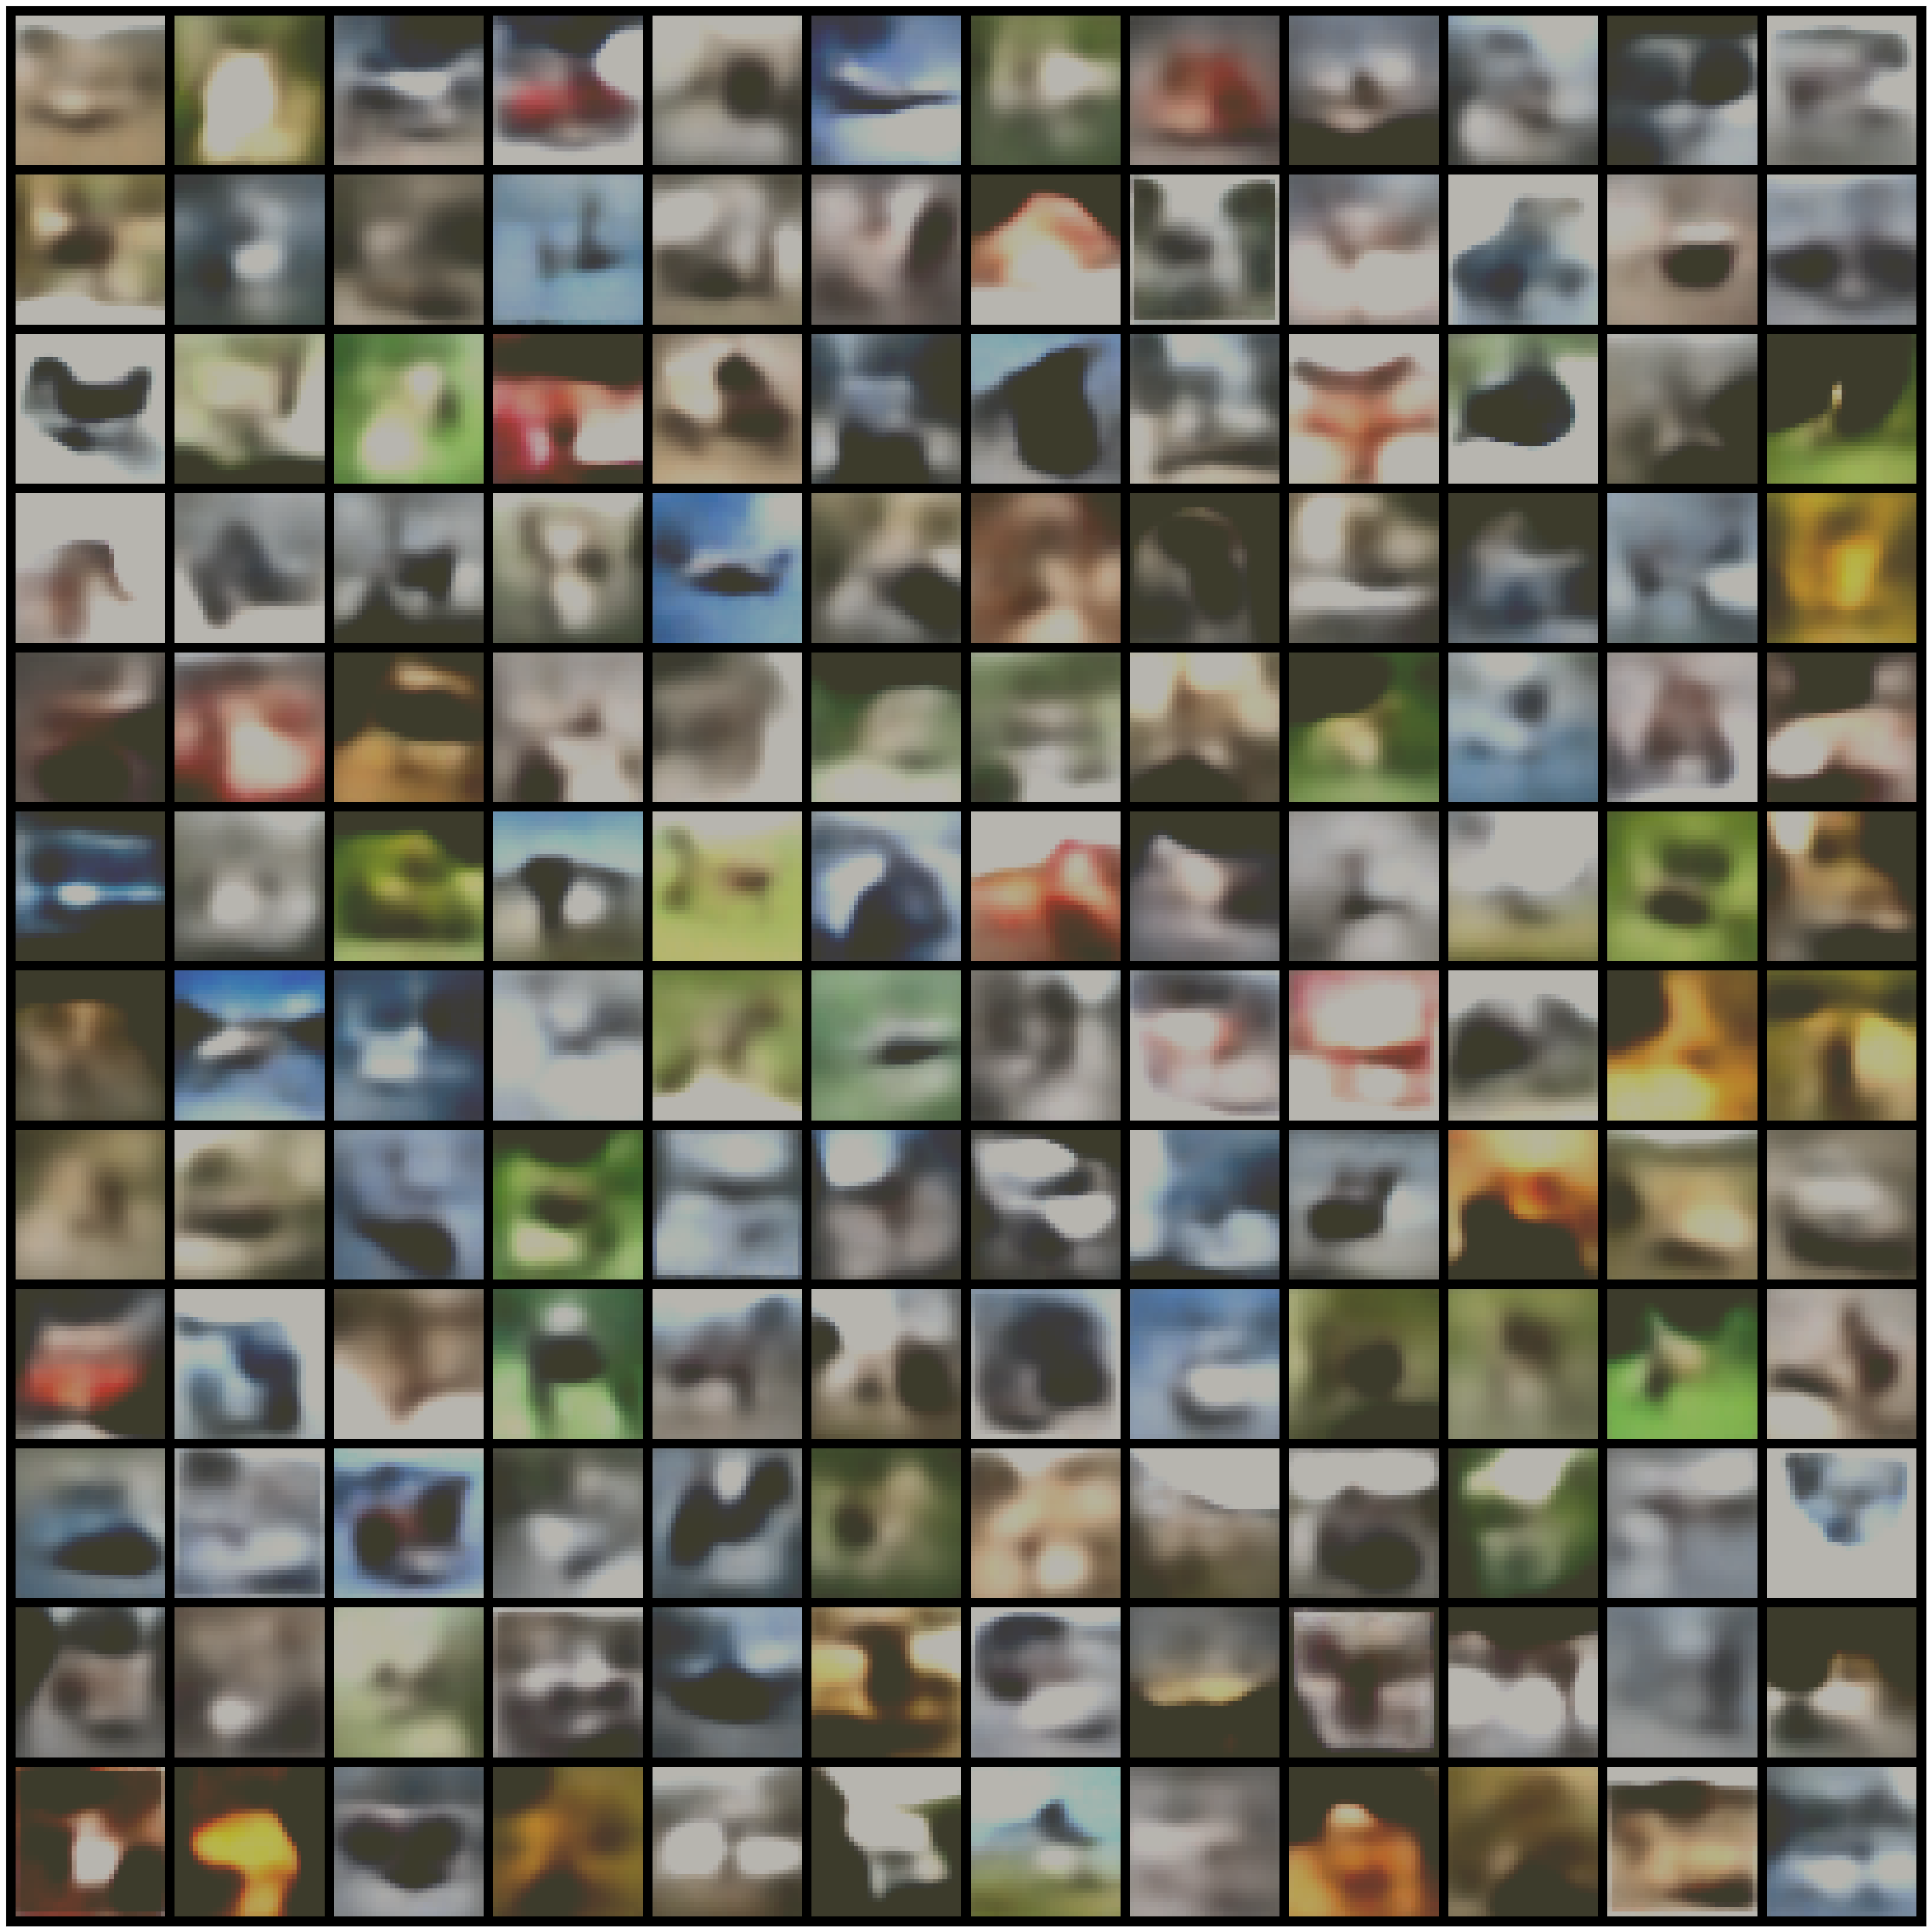

In [17]:
z = torch.randn(144, 256).to(device)

samples = model.decoder(z)

grid = make_grid(invnorm(samples), nrow=12)
show(grid)